In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
from astropy import wcs
import pandas as pd
import sys
from tqdm import tqdm
from astropy.visualization import ZScaleInterval
from glob import glob
import csv
#import seaborn as sns

from multiprocessing import Pool
import time as tm

from uncertainties import ufloat
from scipy import constants as con
from astropy import constants as ascon
from astropy import units as u
#import pyregion

In [4]:
from mrexo import predict_from_measurement, generate_lookup_table

# TSM

https://arxiv.org/pdf/1805.03671.pdf

In [5]:
def TSM(rp, mp, teq, rs, m_J) :
    
    if rp < 1.5:
        scale = 0.190
    elif rp < 2.75:
        scale = 1.26
    elif rp < 4.0:
        scale = 1.28
    else: 
        scale = 1.15
        
    return scale*rp**3 * teq / (mp * rs **2) * 10**(-m_J/5.)

In [6]:
def MR_relation(Rp):
    """Eq. 2 in Kempton+2018
    https://arxiv.org/pdf/1805.03671.pdf
    which is based on Chen & Kipping+2017
    """
    if Rp < 1.23:
        Mp = 0.9718*Rp**3.58
    elif 1.23 < Rp < 14.26:
        Mp =  1.436*Rp**1.70
    else:
        raise ValueError
    return Mp

## TOI 1696.01	/ TIC 470381900.01

In [7]:
Rp_tg = 3.04 #Rearth 
Rp_err_tg = 0.1

Teq_tg  = 477 #pm 24, K
Per_tg = 2.5

Teff_tg  = 3156
Rs_tg  = 0.276

mJ_tg  =12.233
mK_tg  = 11.331

dep_tg=((Rp_tg*6.3781e8)/(Rs_tg*6.957e10))**2

In [8]:
MR_relation(Rp_tg)

9.506913272407434

In [9]:
Mp_tg, Mp_qtls_tg, iron_planet = predict_from_measurement(measurement=Rp_tg , measurement_sigma=Rp_err_tg, dataset='mdwarf',  is_posterior=False, show_plot=False)
#print(Mp_tg, Mp_qtls_tg)

In [10]:
Mp_tg

6.3095990770770936

In [11]:
TSM_tg=TSM(Rp_tg , Mp_tg , Teq_tg , Rs_tg , mJ_tg )
TSM_tg

127.62306519048393

## Importing data from NASA Exoplanet Archive

In [12]:
all_planets = pd.read_csv('../data/PS_2022.01.28_05.09.39.csv', skiprows=290)
all_planets

,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,sy_pnum,...,sy_kepmagerr2,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,1,2,1,...,NaN,2014-05-14,2008-01,2014-05-14,2,1,2,0,0,0
1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,0,2,1,...,NaN,2014-07-23,2011-08,2014-07-23,2,1,2,0,0,0
2,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,1,...,NaN,2018-04-25,2011-08,2014-07-23,0,1,1,0,0,0
3,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,1,...,NaN,2018-09-04,2017-03,2018-09-06,0,1,1,0,0,0
4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,1,...,NaN,2018-04-25,2009-10,2014-05-14,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32052,ups And d,ups And,d,HD 9826,HIP 7513,TIC 189576919,Gaia DR2 348020448377061376,0,2,3,...,NaN,2021-09-20,2021-05,2021-09-20,0,1,10,1,0,0
32053,ups And d,ups And,d,HD 9826,HIP 7513,TIC 189576919,Gaia DR2 348020448377061376,0,2,3,...,NaN,2021-08-03,2010-06,2021-08-03,0,1,10,1,0,0
32054,ups Leo b,ups Leo,b,NaN,NaN,TIC 49430557,Gaia DR2 3794167001116433152,1,1,1,...,NaN,2022-01-10,2021-12,2022-01-10,0,0,0,0,0,0
32055,xi Aql b,xi Aql,b,HD 188310,HIP 97938,TIC 375464367,Gaia DR2 4298361114750843904,0,1,1,...,NaN,2014-07-23,2011-08,2014-07-23,1,1,1,0,0,0


In [13]:
all_planets=all_planets[all_planets['default_flag']==1]
len(all_planets)

4908

In [14]:
planets=all_planets[all_planets['st_teff']<4000]
len(planets)

358

In [31]:
planets=all_planets[all_planets['st_teff']<3800]

#TSM
planets=planets[planets['pl_rade'].notna()]
planets=planets[planets['pl_rade']<10]

planets=planets[planets['pl_orbsmax'].notna()]  
planets=planets[planets['st_rad'].notna()]

planets=planets[planets['sy_jmag'].notna()]
planets=planets.reset_index()
len(planets)

130

### mass calculation

In [32]:
#this will take several minutes
mass_list = []

for r, re in zip(planets['pl_rade'], planets['pl_radeerr1']):
    mass, _, _ = predict_from_measurement(measurement=r , measurement_sigma=re, dataset='mdwarf',  is_posterior=False, show_plot=False)
    mass_list.append(mass)

Mass of 100% Iron planet of 1.047 Earth Radii = 2.9532555947705807 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.13 Earth Radii = 4.063133338971838 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.193 Earth Radii = 5.129589837922454 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.264 Earth Radii = 6.614501710423345 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.217 Earth Radii = 5.595278563380514 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 0.718 Earth Radii = 0.6963610159547223 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.04 Earth Radii = 2.87290802874415 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 0.89 Earth Radii = 1.5451807019906942 Earth Mass (Fortney, Marley and Barnes 2007)
Mass of 100% Iron planet of 1.1 Earth Radii = 3.626567898484023 Earth Mass (Fortney, Marley and Barnes 2007)
Mass

In [33]:
planets['mass_calc'] = mass_list

(0.0, 30.0)

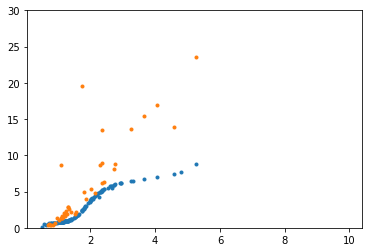

In [34]:
pl.plot(planets['pl_rade'],planets['mass_calc'], '.')
pl.plot(planets['pl_rade'],planets['pl_masse'], '.')
pl.ylim(0, 30)

In [35]:
import math

In [36]:
planets['mass_combine'] = planets['pl_masse']

for i in range(len(planets)):
    if math.isnan(planets['pl_masse'][i])==True:
        planets['mass_combine'][i] =planets['mass_calc'][i]

(0.0, 30.0)

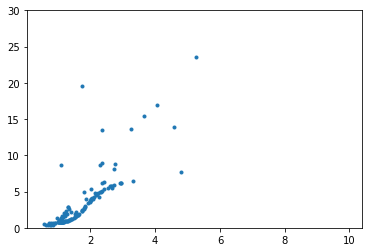

In [37]:
pl.plot(planets['pl_rade'],planets['mass_combine'], '.')
pl.ylim(0, 30)

### Teq Calculation

In [38]:
def Teq(Teff, R_s, semi): #[L_sol]
    R_s_m = R_s * ascon.R_sun
    semi_m = semi * ascon.au
    return Teff * (R_s_m/2./semi_m)**0.5

teff_s = planets['st_teff']
rs_s = planets['st_rad']
a_s = planets['pl_orbsmax']

planets['teq_calc'] = Teq(teff_s, rs_s, a_s)

In [39]:
len(planets)

130

In [40]:
len(planets[planets['pl_eqt'].notna()])

79

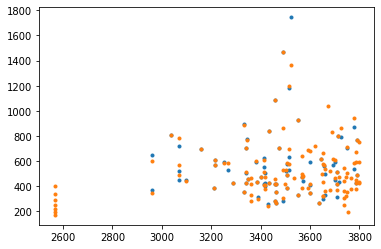

In [41]:
pl.plot(planets['st_teff'], planets['pl_eqt'],'.')
pl.plot(planets['st_teff'], planets['teq_calc'],'.')
#pl.ylim(0,1000)

In [42]:
planets['teq_combine'] = planets['pl_eqt']

for i in range(len(planets)):
    if math.isnan(planets['pl_eqt'][i])==True:
        planets['teq_combine'][i] =planets['teq_calc'][i]

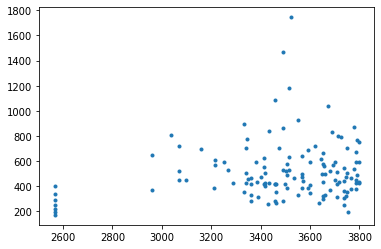

In [43]:
pl.plot(planets['st_teff'], planets['teq_combine'],'.')

# TSM Calculation

In [44]:
Rp = planets['pl_rade']

#Mp = planets['pl_masse']
Mp = planets['mass_combine']

#Teq = planets['pl_eqt']
Teq = planets['teq_combine']

Rs = planets['st_rad']
mJ = planets['sy_jmag']

tsm=[]
for n in range(len(Rp)):
    tsm.append(TSM(Rp[n], Mp[n], Teq[n], Rs[n], mJ[n]))

planets['TSM'] = tsm
planets_TSM = planets

In [53]:
df=planets_TSM.sort_values('TSM', ascending=False).loc[:,['pl_name','TSM', 'pl_eqt', 'pl_rade' ,'pl_orbper']].reset_index()
df

,index,pl_name,TSM,pl_eqt,pl_rade,pl_orbper
0,5,GJ 1214 b,482.123733,596.0,2.742,1.580404
1,0,AU Mic b,393.336558,593.0,4.070,8.463000
2,89,L 98-59 d,273.657452,416.0,1.521,7.450724
3,7,GJ 3470 b,270.204580,594.0,4.570,3.336650
4,117,TOI-674 b,215.148782,635.0,5.250,1.977143
...,...,...,...,...,...,...
125,64,Kepler-225 b,1.320719,NaN,1.200,6.738975
126,93,LHS 1815 b,1.205775,617.0,1.088,3.814330
127,63,Kepler-186 f,0.842309,NaN,1.170,129.944100
128,23,K2-137 b,0.028423,1471.0,0.890,0.179715


In [54]:
Rp_plot = list(df['pl_rade'])
Rp_plot.append(Rp_tg)

Per_plot = list(df['pl_orbper'])
Per_plot.append(Per_tg)

eq_plot = list(df['pl_eqt'])
eq_plot.append(Teq_tg)
#eq_plot

tsm_plot=list(df['TSM'])
tsm_plot.append(TSM_tg)

# hmag_plot = list(df['sy_hmag'])
#hmag_plot.append(11.604)

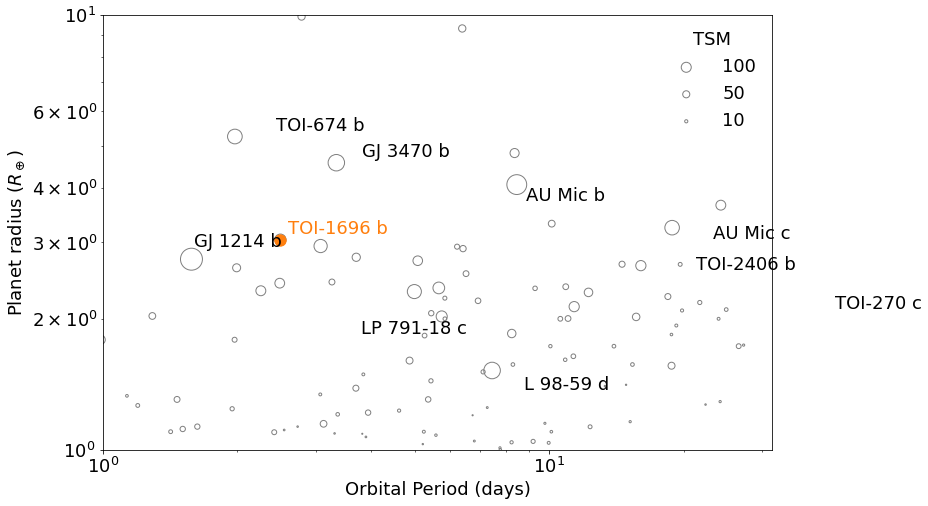

In [55]:
from adjustText import adjust_text

pl.rcParams['font.size'] = 18
f = pl.figure(figsize=(12,8))

legends,labels = [],[]
for i in [100,50,10]:
    l = pl.scatter([],[], s=i, facecolor='None', edgecolors='gray')
    legends.append(l)
    labels.append(str(i))

sc = pl.scatter(Per_plot, Rp_plot,  alpha=1, s=tsm_plot,  
               facecolor='None', edgecolors='gray'
              )

pl.scatter(Per_tg, Rp_tg,  c='C1', s=TSM_tg)
pl.text(Per_tg+0.1, Rp_tg+0.1, 'TOI-1696 b', c='C1')

texts = []
for n,row in planets_TSM.iterrows():
    if row['TSM']>TSM_tg:
        t = pl.text(row['pl_orbper'],
                    row['pl_rade'],
                    row['pl_name']
                   )
        texts.append(t)
adjust_text(texts, 
#             arrowprops=dict(arrowstyle='-', color='red', lw=0.5),
#             autoalign='', 
#             only_move={'points':'x', 'text':'x'}
           )

pl.xlabel('Orbital Period (days)')
pl.ylabel(r'Planet radius $(R_\oplus)$')
leg = pl.legend(legends, labels, 
                ncol=1, 
                frameon=False, 
#                 handlelength=2, 
#                 loc=1, 
#                 borderpad=1.8,
                handletextpad=1, 
                title='TSM', 
                scatterpoints=1)

pl.loglog()
pl.xlim(1,10**1.5)
pl.ylim(1, 10**1)

f.savefig('../paper/figures/TSM_scatter.png')

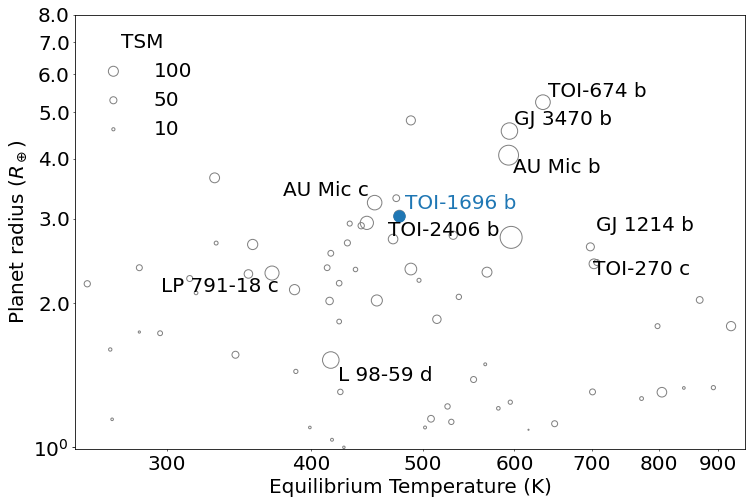

In [59]:
from adjustText import adjust_text
import matplotlib.ticker as mticker

pl.rcParams['font.size'] = 20

f, ax = pl.subplots(figsize=(12,8))

legends,labels = [],[]
for i in [100,50,10]:
    l = pl.scatter([],[], s=i, facecolor='None', edgecolors='gray')
    legends.append(l)
    labels.append(str(i))

ax.scatter(eq_plot, Rp_plot,  alpha=1, s=tsm_plot,  facecolor='None', edgecolors='gray')
ax.scatter(Teq_tg, Rp_tg,  s=TSM_tg, c='C0')
ax.text(Teq_tg+5, Rp_tg+0.1, 'TOI-1696 b', c='C0')

texts = []
for n,row in planets_TSM.iterrows():
    if row['TSM']>TSM_tg:
        t = pl.text(row['pl_eqt'],
                    row['pl_rade'],
                    row['pl_name']
                   )
        texts.append(t)
adjust_text(texts, 
#             arrowprops=dict(arrowstyle='-', color='red'),
#             autoalign='',
#             only_move={'points':'x', 'text':'x'},
#             expand_text=(1, 2), # We want them to be quite compact, so reducing expansion makes sense
            force_text=(0.75, 0), force_objects=(1, 0), #With default forces it takes a very long time to converge
           )

ax.set_xlabel('Equilibrium Temperature (K)')
ax.set_ylabel(r'Planet radius $(R_\oplus)$')
leg = pl.legend(legends, labels, 
                loc='upper left',
                ncol=1, 
                frameon=False, 
#                 handlelength=2, 
#                 loc=1, 
#                 borderpad=1.8,
                handletextpad=1, 
                title='TSM', 
                scatterpoints=1)

ax.set_xlim(250,950)
ax.set_ylim(0.99, 8)
pl.loglog()
# ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
f.savefig('../paper/figures/TSM_scatter_new.png', bbox_inches='tight')